In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
!curl -k -o helper_functions.py https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10246  100 10246    0     0  24509      0 --:--:-- --:--:-- --:--:-- 24689


In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [5]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    shuffle=True
)

test_data_10_precent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=IMG_SIZE,
    shuffle=True
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
for images, labels in train_data_10_percent.take(1): # `.take()` Takes the Number of batches that you mention EX. 1 in this case
  print(images, labels)

tf.Tensor(
[[[[8.83571396e+01 7.03571396e+01 5.83571434e+01]
   [8.80000000e+01 7.00000000e+01 5.80000000e+01]
   [9.00392227e+01 7.20392227e+01 5.96106491e+01]
   ...
   [1.46144684e+02 1.47716156e+02 1.46501892e+02]
   [2.61746101e+01 3.23889351e+01 3.03174934e+01]
   [1.63468208e+01 2.71115017e+01 2.12291622e+01]]

  [[8.81610336e+01 7.01610336e+01 5.81610336e+01]
   [8.80000000e+01 7.00000000e+01 5.80000000e+01]
   [9.02142868e+01 7.22142868e+01 5.97857132e+01]
   ...
   [1.46644119e+02 1.48215591e+02 1.47001328e+02]
   [3.11232262e+01 3.73375511e+01 3.52661095e+01]
   [1.76650047e+01 2.69871025e+01 2.29242668e+01]]

  [[8.67579727e+01 6.87579727e+01 5.67579727e+01]
   [8.79346313e+01 6.99346313e+01 5.79346313e+01]
   [8.92991104e+01 7.12991104e+01 5.88705330e+01]
   ...
   [1.46522995e+02 1.46656296e+02 1.46161118e+02]
   [3.28435555e+01 3.71621399e+01 3.60058784e+01]
   [1.68872299e+01 2.58872299e+01 2.28872299e+01]]

  ...

  [[6.70908966e+01 5.20303001e+01 4.50303001e+01]
   [6

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x) # (x) at the end refers to passing on to the next func
print(f"Shape after GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_precent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_precent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20241127-192026
Epoch 1/5
24/24 [==============================] - 13s 179ms/step - loss: 1.9678 - accuracy: 0.3800 - val_loss: 1.3829 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 3s 111ms/step - loss: 1.1940 - accuracy: 0.7520 - val_loss: 0.9583 - val_accuracy: 0.7845
Epoch 3/5
24/24 [==============================] - 3s 108ms/step - loss: 0.8543 - accuracy: 0.8187 - val_loss: 0.7614 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 3s 110ms/step - loss: 0.7007 - accuracy: 0.8400 - val_loss: 0.6871 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 3s 113ms/step - loss: 0.5991 - accuracy: 0.8773 - val_loss: 0.5980 - val_accuracy: 0.8355


In [11]:
model_0.evaluate(test_data_10_precent)

79/79 [==============================] - 6s 67ms/step - loss: 0.5774 - accuracy: 0.8560


[0.5773810744285583, 0.8560000061988831]

In [12]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [13]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


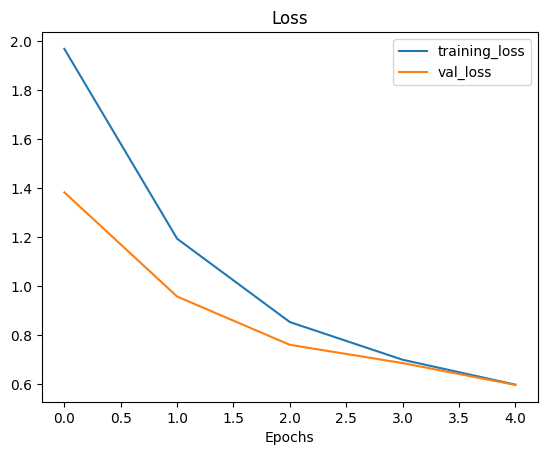

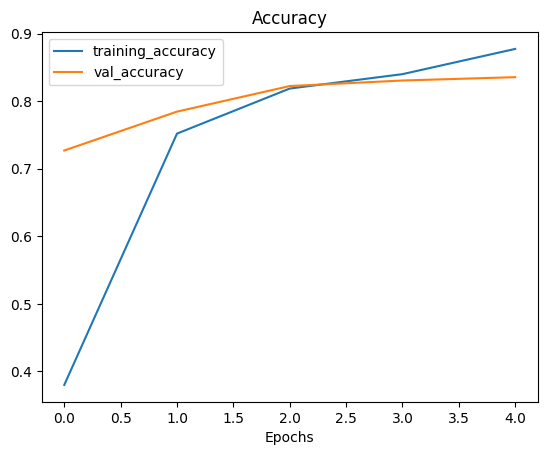

In [15]:
plot_loss_curves(history_10_percent)

- Shape after `base_model`: **(None, 7, 7, 1280)**
- After `GlobalAveragePooling2D()`: **(None, 1280)**

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [16]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [17]:
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooling_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [18]:
# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooling_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [19]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. **Model 1**: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. **Model 2**: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. **Model 3**: Fine-tune the **Model 2** checkpoint on 10% of the training data with data augmentation.
4. **Model 4**: Fine-tune the **Model 2** checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the **same test dataset**, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetV2B0` model within the `tf.keras.applications.efficientnet_v2` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [20]:
!curl -k -o 10_food_classes_1_percent.zip https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  127M    0 49273    0     0  54316      0  0:40:59 --:--:--  0:40:59 54565
  0  127M    0  769k    0     0   421k      0  0:05:09  0:00:01  0:05:08  422k
 10  127M   10 13.5M    0     0  4917k      0  0:00:26  0:00:02  0:00:24 4925k
 23  127M   23 30.0M    0     0  8043k      0  0:00:16  0:00:03  0:00:13 8051k
 37  127M   37 48.0M    0     0   9.9M      0  0:00:12  0:00:04  0:00:08  9.9M
 52  127M   52 67.4M    0     0  11.5M      0  0:00:11  0:00:05  0:00:06 13.6M
 68  127M   68 87.1M    0     0  12.6M      0  0:00:10  0:00:06  0:00:04 17.0M
 79  127M   79  101M    0     0  12.9M      0  0:00:09  0:00:07  0:00:02 17.5M
 94  127M   94  120M    0     0  13.6M      0  0:00:09  0:00:08  0:00:01 17.9M
100  127M  100  127M    0     0  13.8M      0  0:00

In [21]:
unzip_data("10_food_classes_1_percent.zip")

In [22]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [23]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [24]:
img_size = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
                                                                            train_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            batch_size=32,
                                                                            image_size=img_size
                                                                        )

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
                                                                            test_dir_1_percent,
                                                                            label_mode="categorical",
                                                                            batch_size=32,
                                                                            image_size=img_size
                                                                        )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Awesome!

We've got 10x more images to work with, 75 per class instead of 7 per class.

Let's build a model with data augmentation built in. We could reuse the data augmentation Sequential model we created before but we'll recreate it to practice.

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.Rescaling(1./255), # keep for ResNet50V2, remove for EfficientNet
], name = "data_augmentation")

### **AIM** : To Visualize a random image befire and after *augmentation* 

In [26]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

10_food_classes_1_percent/train/fried_rice/2980189.jpg


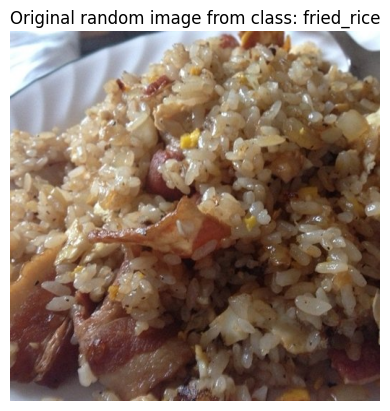

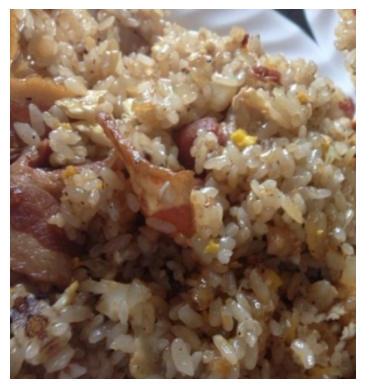

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

# This method returns the list of all files and directories in the specified path. The return type of this method is list.
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes
print(random_image_path)

augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img)
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [28]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False
)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

x = data_augmentation(inputs)

x = base_model(x, training = False)

x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data_1_percent,
                    validation_steps=int(0.25* len(test_data_1_percent)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20241127-192114
Epoch 1/5
3/3 [==============================] - 11s 1s/step - loss: 2.3304 - accuracy: 0.1000 - val_loss: 2.3426 - val_accuracy: 0.1086
Epoch 2/5
3/3 [==============================] - 2s 785ms/step - loss: 2.3491 - accuracy: 0.1143 - val_loss: 2.3587 - val_accuracy: 0.1069
Epoch 3/5
3/3 [==============================] - 2s 765ms/step - loss: 2.3764 - accuracy: 0.0714 - val_loss: 2.3445 - val_accuracy: 0.1168
Epoch 4/5
3/3 [==============================] - 2s 800ms/step - loss: 2.3323 - accuracy: 0.0857 - val_loss: 2.3288 - val_accuracy: 0.1118
Epoch 5/5
3/3 [==============================] - 2s 787ms/step - loss: 2.3289 - accuracy: 0.1286 - val_loss: 2.3360 - val_accuracy: 0.0987


In [29]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [30]:
model_1.evaluate(test_data_1_percent)

79/79 [==============================] - 5s 62ms/step - loss: 2.3386 - accuracy: 0.1000


[2.3385653495788574, 0.10000000149011612]

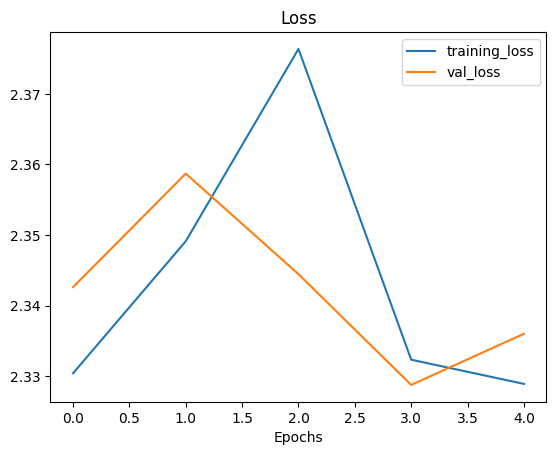

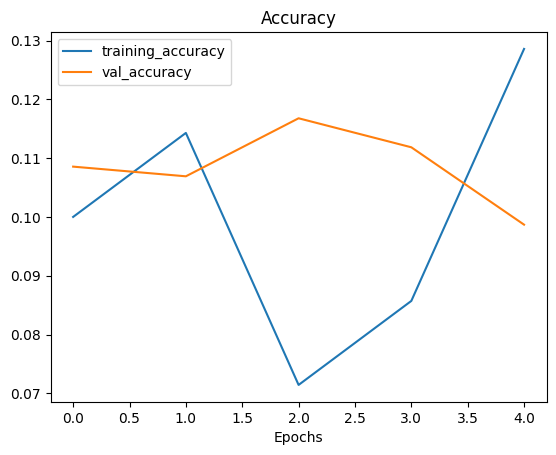

In [31]:
plot_loss_curves(history_1_percent)

In [32]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

In [33]:
img_size = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode = "categorical",
    image_size = img_size
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10_percent,
    label_mode = "categorical",
    image_size = img_size
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percen

In [35]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

data_aug = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.Rescaling(1/255),
], name = "data_aug")

In [36]:
input_shape = (224, 224, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_layer = layers.Input(shape = input_shape, name = "input_layer")

x = data_aug(input_layer)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

outputs = layers.Dense(10, activation = "softmax", name = "ouput_layer")(x)

model_2 = tf.keras.Model(input_layer, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# Fit the model
history_2_percent = model_2.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data_10_percent,
                    validation_steps=int(0.25* len(test_data_10_percent)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241127-192143
Epoch 1/5
24/24 [==============================] - 17s 349ms/step - loss: 2.3446 - accuracy: 0.1080 - val_loss: 2.3408 - val_accuracy: 0.1053
Epoch 2/5
24/24 [==============================] - 7s 279ms/step - loss: 2.3526 - accuracy: 0.0773 - val_loss: 2.3171 - val_accuracy: 0.1118
Epoch 3/5
24/24 [==============================] - 7s 301ms/step - loss: 2.3310 - accuracy: 0.0827 - val_loss: 2.3158 - val_accuracy: 0.0905
Epoch 4/5
24/24 [==============================] - 7s 298ms/step - loss: 2.3405 - accuracy: 0.0693 - val_loss: 2.3181 - val_accuracy: 0.1151
Epoch 5/5
24/24 [==============================] - 8s 324ms/step - loss: 2.3290 - accuracy: 0.1053 - val_loss: 2.3277 - val_accuracy: 0.1118


### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [37]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [38]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [39]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data_10_percent,
                                          validation_steps=int(0.25 * len(test_data_10_percent)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20241127-192233
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0372 - accuracy: 0.3453
Epoch 1: val_loss improved from inf to 1.45653, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 17s 378ms/step - loss: 2.0372 - accuracy: 0.3453 - val_loss: 1.4565 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4333 - accuracy: 0.6587
Epoch 2: val_loss improved from 1.45653 to 1.05151, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 7s 289ms/step - loss: 1.4333 - accuracy: 0.6587 - val_loss: 1.0515 - val_accuracy: 0.7829
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0991 - accuracy: 0.7347
Epoch 3: val_loss improved from 1.05151 to 0.83678, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==

In [40]:
results_10_percent_data_aug = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 5s 65ms/step - loss: 0.6515 - accuracy: 0.8324


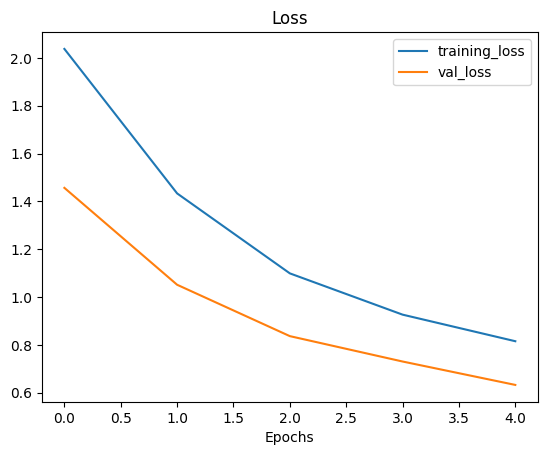

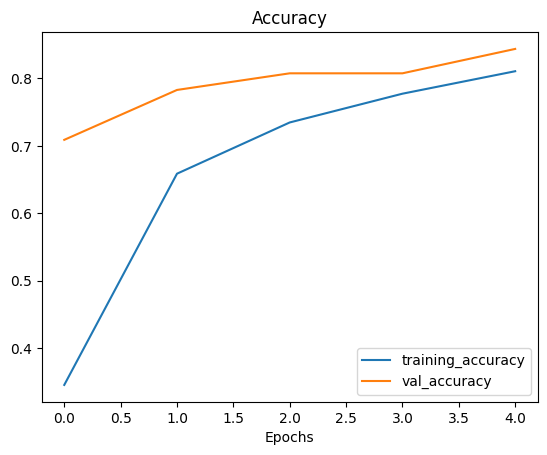

In [41]:
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the [`load_weights()`](https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options) method, passing it the path where your saved weights are stored.

In [42]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 72ms/step - loss: 0.6515 - accuracy: 0.8324


In [43]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

In [44]:
results_10_percent_data_aug

[0.6514998078346252, 0.8324000239372253]

In [45]:
loaded_weights_model_results

[0.6514996290206909, 0.8324000239372253]

In [46]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [47]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.78813934e-07 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (`EfficientNetV2B0`) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

In [53]:
# Layers in loaded model
model_2.layers

In [54]:
for layer_number, layer in enumerate(model_2.layers):
  print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.engine.input_layer.InputLayer object at 0x00000290EDB7AAC0> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.engine.sequential.Sequential object at 0x00000290E9143A90> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.engine.functional.Functional object at 0x00000290ED9F8CA0> | Trainable? True
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x00000290EDA12CD0> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.layers.core.dense.Dense object at 0x00000290E0323220> | Trainable? True


In [55]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [49]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 5s 54ms/step - loss: 0.6515 - accuracy: 0.8324


[0.6514999866485596, 0.8324000239372253]

In [50]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [51]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [52]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_5 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [57]:
# Make all the layers in model_2_base_model trainable
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [58]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_5 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [59]:
print(len(model_2.trainable_variables))

12


In [60]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data_10_percent,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data_10_percent)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20241127-204255
Epoch 5/15
24/24 [==============================] - 20s 400ms/step - loss: 0.7152 - accuracy: 0.7973 - val_loss: 0.5252 - val_accuracy: 0.8273
Epoch 6/15
24/24 [==============================] - 8s 332ms/step - loss: 0.5684 - accuracy: 0.8333 - val_loss: 0.4596 - val_accuracy: 0.8487
Epoch 7/15
24/24 [==============================] - 8s 311ms/step - loss: 0.5473 - accuracy: 0.8227 - val_loss: 0.4543 - val_accuracy: 0.8421
Epoch 8/15
24/24 [==============================] - 7s 304ms/step - loss: 0.4883 - accuracy: 0.8520 - val_loss: 0.4585 - val_accuracy: 0.8388
Epoch 9/15
24/24 [==============================] - 8s 325ms/step - loss: 0.4760 - accuracy: 0.8507 - val_loss: 0.3984 - val_accuracy: 0.8553
Epoch 10/15
24/24 [==============================] - 8s 332ms/step - loss: 0.4374 - accuracy: 0.8640 - val_loss: 0.4563 - val_accuracy: 0.8388
Epoch 11/15
24/24 [==============================]

In [61]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 6s 72ms/step - loss: 0.4116 - accuracy: 0.8608


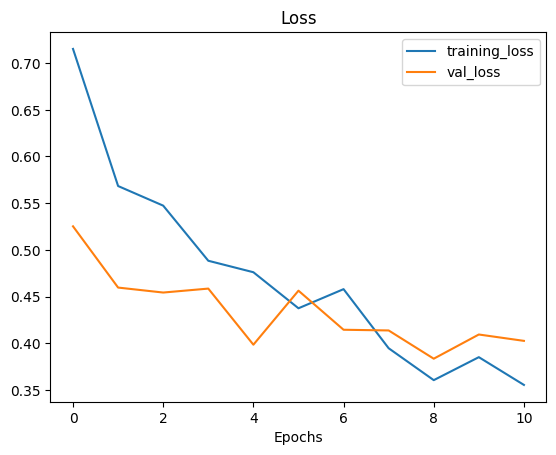

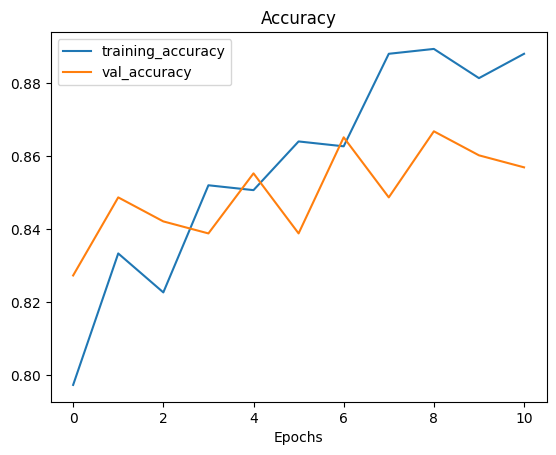

In [62]:
plot_loss_curves(history_fine_10_percent_data_aug)

Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [63]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
16
[0.3453333377838135, 0.6586666703224182, 0.734666645526886, 0.7773333191871643, 0.8106666803359985, 0.7973333597183228, 0.8333333134651184, 0.8226666450500488, 0.8519999980926514, 0.8506666421890259, 0.8640000224113464, 0.862666666507721, 0.8880000114440918, 0.8893333077430725, 0.8813333511352539, 0.8880000114440918]


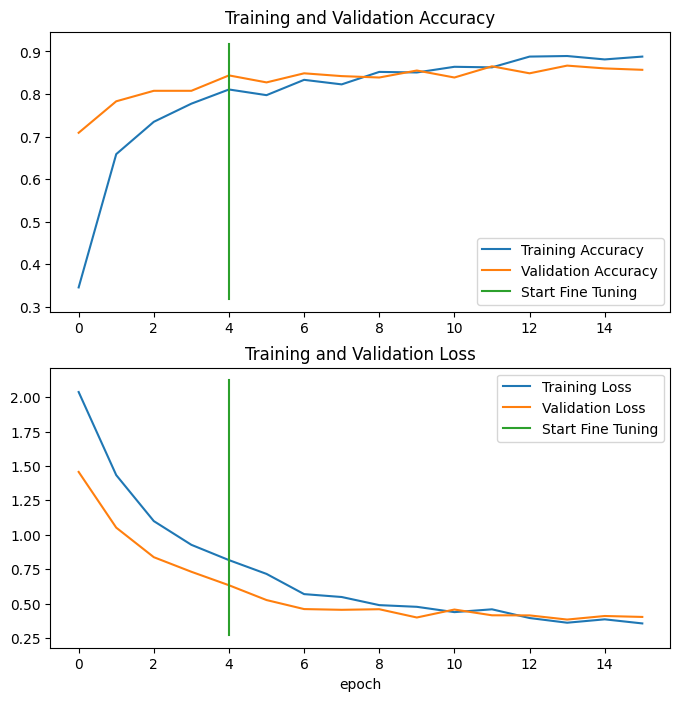

In [64]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.

In [66]:
# Download and unzip 10 classes of data with all images
!curl -k -o 10_food_classes_all_data.zip https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  495M    0 10369    0     0  23110      0  6:14:25 --:--:--  6:14:25 23196
  0  495M    0  141k    0     0   126k      0  1:06:50  0:00:01  1:06:49  126k
  0  495M    0 2976k    0     0  1414k      0  0:05:58  0:00:02  0:05:56 1415k
  4  495M    4 21.4M    0     0  7096k      0  0:01:11  0:00:03  0:01:08 7099k
  8  495M    8 40.8M    0     0   9.9M      0  0:00:49  0:00:04  0:00:45  9.9M
 12  495M   12 60.0M    0     0  11.7M      0  0:00:42  0:00:05  0:00:37 12.8M
 15  495M   15 78.2M    0     0  12.7M      0  0:00:38  0:00:06  0:00:32 15.6M
 19  495M   19 97.0M    0     0  13.4M      0  0:00:36  0:00:07  0:00:29 18.3M
 23  495M   23  115M    0     0  14.1M      0  0:00:35  0:00:08  0:00:27 18.5M
 27  495M   27  134M    0     0  14.6M      0  0:00

In [67]:
# Setup data directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir_all_data = "10_food_classes_all_data/test/"

In [68]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data\test'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\steak'.
There are 0 directories and 250 images in '10_food_classes_all_data\test\sushi'.
There are 

In [70]:
img_size = (224, 224)

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode='categorical',
    batch_size=32,
    image_size=img_size,
)

test_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_all_data,
    label_mode='categorical',
    batch_size=32,
    image_size=img_size,
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [71]:
model_2.evaluate(test_data_10_classes_full)

79/79 [==============================] - 6s 72ms/step - loss: 0.4116 - accuracy: 0.8608


[0.41162827610969543, 0.86080002784729]

To keep our experiments clean, we'll load a create a new instance of `model_2` using our `create_base_model()` function.

More specifically, we're trying to measure:
* **Experiment 3 (previous one)** - `model_2` with 10 layers fine-tuned for 5 more epochs on 10% of the data.
* **Experiment 4 (this one)** - `model_2` with layers fined-tuned for 5 more epochs on 100% on the data.

Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (`model_2` feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of `model_2`.

In [72]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_layer True
4 output_layer True


In [73]:
# Unfreeze the top 10 layers in model_2's base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [74]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_5 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [75]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [77]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 10

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data_10_classes_full,
                                           validation_steps=int(0.25 * len(test_data_10_classes_full)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20241127-220025
Epoch 5/15
235/235 [==============================] - 62s 230ms/step - loss: 0.6508 - accuracy: 0.7941 - val_loss: 0.3631 - val_accuracy: 0.8651
Epoch 6/15
235/235 [==============================] - 43s 181ms/step - loss: 0.5687 - accuracy: 0.8167 - val_loss: 0.3081 - val_accuracy: 0.8849
Epoch 7/15
235/235 [==============================] - 42s 177ms/step - loss: 0.5308 - accuracy: 0.8295 - val_loss: 0.2938 - val_accuracy: 0.8964
Epoch 8/15
235/235 [==============================] - 42s 176ms/step - loss: 0.4826 - accuracy: 0.8440 - val_loss: 0.2888 - val_accuracy: 0.8914
Epoch 9/15
235/235 [==============================] - 41s 173ms/step - loss: 0.4701 - accuracy: 0.8497 - val_loss: 0.2373 - val_accuracy: 0.9145
Epoch 10/15
235/235 [==============================] - 40s 171ms/step - loss: 0.4391 - accuracy: 0.8567 - val_loss: 0.2456 - val_accuracy: 0.9046
Epoch 11/15
235/235 [=======

In [78]:
results_fine_tune_full_data = model_2.evaluate(test_data_10_classes_full)
results_fine_tune_full_data

79/79 [==============================] - 6s 72ms/step - loss: 0.2459 - accuracy: 0.9192


[0.24586525559425354, 0.9192000031471252]

In [79]:
results_fine_tune_10_percent

[0.4116278886795044, 0.86080002784729]

5
16
[0.3453333377838135, 0.6586666703224182, 0.734666645526886, 0.7773333191871643, 0.8106666803359985, 0.7941333055496216, 0.8166666626930237, 0.8294666409492493, 0.843999981880188, 0.8497333526611328, 0.8566666841506958, 0.8622666597366333, 0.8678666949272156, 0.8725333213806152, 0.8733333349227905, 0.8848000168800354]


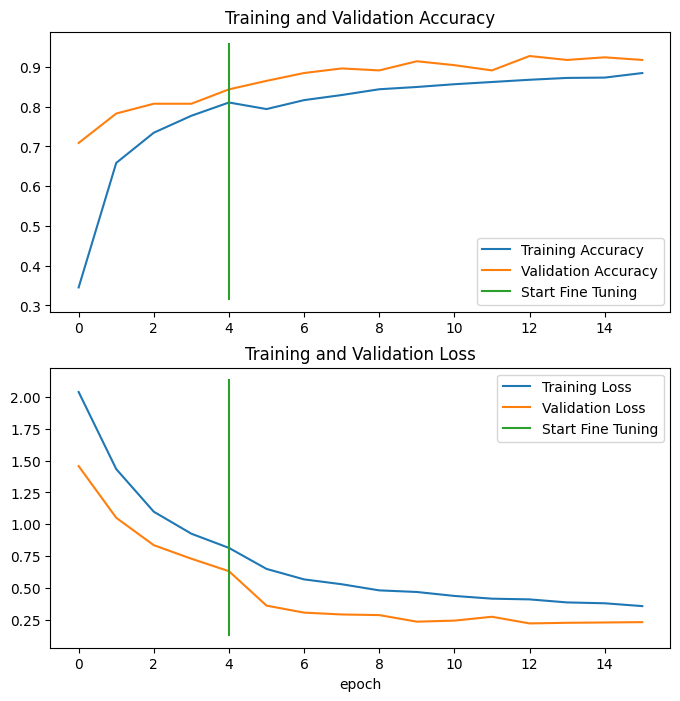

In [80]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [82]:
%load_ext tensorboard
%tensorboard --logdir=transfer_learning

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10516), started 0:00:27 ago. (Use '!kill 10516' to kill it.)